# Research Question 1 - Order-Invariant Assumption

In [1]:
import pickle

with open("data/human.pkl", "rb") as human, open("data/comet.pkl", "rb") as comet:
    experiments = pickle.load(human) + pickle.load(comet)

print(f"Total number of experiments: {len(experiments)}")

Total number of experiments: 23


## Analysis on Prediction

In [2]:
import pandas as pd

HUMAN_NEEDS = ("status", "approval", "tranquility", "competition", "health", "family", "romance", "food",
               "independence","power", "order", "curiosity", "serenity", "honor", "belonging", "contact",
               "savings", "idealism", "rest")

predictions = pd.DataFrame(
    ((e.story, e.sentence, e.character, i.human_size, i.machine_size, need, value)
     for e in experiments for i in e.instances for s in i.samples
     for need, value in zip(HUMAN_NEEDS, s.result)),
    columns=("story", "line", "character", "human_size", "machine_size", "need", "value")
)

predictions

,story,line,character,human_size,machine_size,need,value
0,0428b530-0cec-4955-b023-0bac60ddf8cc,5,Gina,0,0,status,0.469050
1,0428b530-0cec-4955-b023-0bac60ddf8cc,5,Gina,0,0,approval,0.419768
2,0428b530-0cec-4955-b023-0bac60ddf8cc,5,Gina,0,0,tranquility,0.340969
3,0428b530-0cec-4955-b023-0bac60ddf8cc,5,Gina,0,0,competition,0.435739
4,0428b530-0cec-4955-b023-0bac60ddf8cc,5,Gina,0,0,health,0.312782
...,...,...,...,...,...,...,...
11232795,7a45afb8-18c4-4397-8751-6d8332d88178,5,Tycho,3,66,belonging,0.000335
11232796,7a45afb8-18c4-4397-8751-6d8332d88178,5,Tycho,3,66,contact,0.067039
11232797,7a45afb8-18c4-4397-8751-6d8332d88178,5,Tycho,3,66,savings,0.113374
11232798,7a45afb8-18c4-4397-8751-6d8332d88178,5,Tycho,3,66,idealism,0.189569


In [3]:
predictions = predictions.groupby(["story", "line", "character"])\
    .apply(lambda x: x[(x.human_size == 0) & (x.machine_size == x.machine_size.max())])\
    .reset_index(drop=True)[["story", "line", "character", "need", "value"]]

predictions

,story,line,character,need,value
0,0428b530-0cec-4955-b023-0bac60ddf8cc,5,Gina,status,0.481567
1,0428b530-0cec-4955-b023-0bac60ddf8cc,5,Gina,approval,0.310710
2,0428b530-0cec-4955-b023-0bac60ddf8cc,5,Gina,tranquility,0.039941
3,0428b530-0cec-4955-b023-0bac60ddf8cc,5,Gina,competition,0.401482
4,0428b530-0cec-4955-b023-0bac60ddf8cc,5,Gina,health,0.035084
...,...,...,...,...,...
43695,b33a2445-7421-4ace-9837-e8f165524ccf,3,Riley,belonging,0.000014
43696,b33a2445-7421-4ace-9837-e8f165524ccf,3,Riley,contact,0.288310
43697,b33a2445-7421-4ace-9837-e8f165524ccf,3,Riley,savings,0.093079
43698,b33a2445-7421-4ace-9837-e8f165524ccf,3,Riley,idealism,0.405672


### Float 32 Test

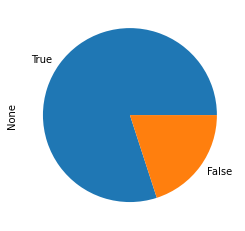

False


/home/hwang99/.anaconda3/envs/haicor-experiment/lib/python3.8/site-packages/scipy/stats/morestats.py:2958: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


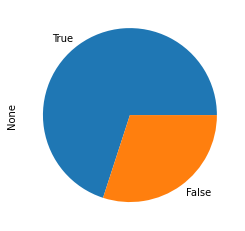

/home/hwang99/.anaconda3/envs/haicor-experiment/lib/python3.8/site-packages/scipy/stats/morestats.py:2958: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/hwang99/.anaconda3/envs/haicor-experiment/lib/python3.8/site-packages/scipy/stats/morestats.py:2972: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


False


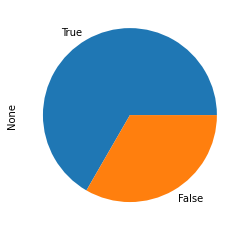

False


/home/hwang99/.anaconda3/envs/haicor-experiment/lib/python3.8/site-packages/scipy/stats/morestats.py:2958: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/hwang99/.anaconda3/envs/haicor-experiment/lib/python3.8/site-packages/scipy/stats/morestats.py:2972: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [4]:
import itertools
from scipy import stats
import matplotlib.pyplot as plt

for key, group in predictions.groupby(["story", "line", "character", "need"]):
    differences = pd.Series(abs(i - j) for i, j in itertools.combinations(group.value.unique(), 2))
    
    if len(differences) > 0 and differences.where(differences > 2 ** -23).count() > 0:
        (differences < 2 ** -23).value_counts().plot.pie()
        plt.show()
        
        print(stats.wilcoxon(differences - 2 ** -23, alternative="greater").pvalue < 0.001)

## Analysis on Attention

In [5]:
attentions = pd.DataFrame(
    ((e.story, e.sentence, e.character, i.human_size, i.machine_size, p.content, p.weight)
     for e in experiments for i in e.instances for s in i.samples
     for p in itertools.chain(s.human_paths, s.machine_paths)),
    columns=("story", "line", "character", "human_size", "machine_size", "path", "value")
)

attentions

,story,line,character,human_size,machine_size,path,value
0,0428b530-0cec-4955-b023-0bac60ddf8cc,5,Gina,0,1,idealism related to realism related to indepen...,1.000000e+00
1,0428b530-0cec-4955-b023-0bac60ddf8cc,5,Gina,0,1,grateful related to pleasing related to cheer ...,1.000000e+00
2,0428b530-0cec-4955-b023-0bac60ddf8cc,5,Gina,0,1,safety is a condition related to fair related ...,1.000000e+00
3,0428b530-0cec-4955-b023-0bac60ddf8cc,5,Gina,0,1,ugly related to unattractive related to power,1.000000e+00
4,0428b530-0cec-4955-b023-0bac60ddf8cc,5,Gina,0,1,grateful related to gratitude related to grace...,1.000000e+00
...,...,...,...,...,...,...,...
19615595,7a45afb8-18c4-4397-8751-6d8332d88178,5,Tycho,3,66,curiosity causes desire read related to magazi...,1.541623e-19
19615596,7a45afb8-18c4-4397-8751-6d8332d88178,5,Tycho,3,66,family is a people has a eat,4.477521e-20
19615597,7a45afb8-18c4-4397-8751-6d8332d88178,5,Tycho,3,66,order Synonym degree related to doctorate deri...,1.466785e-19
19615598,7a45afb8-18c4-4397-8751-6d8332d88178,5,Tycho,3,66,calm related to still Etymologicallyrelated to...,3.290065e-19


In [6]:
attentions = attentions.groupby(["story", "line", "character"])\
    .apply(lambda x: x[(x.human_size == 0) & (x.machine_size == x.machine_size.max())])\
    .reset_index(drop=True)[["story", "line", "character", "path", "value"]]

attentions

,story,line,character,path,value
0,0428b530-0cec-4955-b023-0bac60ddf8cc,5,Gina,love causes desire paint related to ugly,5.907698e-15
1,0428b530-0cec-4955-b023-0bac60ddf8cc,5,Gina,status related to position related to stand re...,1.699289e-16
2,0428b530-0cec-4955-b023-0bac60ddf8cc,5,Gina,pretend HasSubevent fun has property free rela...,2.290936e-10
3,0428b530-0cec-4955-b023-0bac60ddf8cc,5,Gina,leftover is a remainder related to possession ...,3.979581e-02
4,0428b530-0cec-4955-b023-0bac60ddf8cc,5,Gina,grateful related to gratitude related to grace...,9.867313e-16
...,...,...,...,...,...
145495,b33a2445-7421-4ace-9837-e8f165524ccf,3,Riley,status has context medicine related to take An...,1.076834e-08
145496,b33a2445-7421-4ace-9837-e8f165524ccf,3,Riley,good related to well related to health,1.405424e-08
145497,b33a2445-7421-4ace-9837-e8f165524ccf,3,Riley,drop manner of fall related to power,4.210287e-03
145498,b33a2445-7421-4ace-9837-e8f165524ccf,3,Riley,class related to order,1.464978e-02


### Float 32 Test

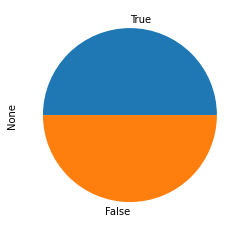

/home/hwang99/.anaconda3/envs/haicor-experiment/lib/python3.8/site-packages/scipy/stats/morestats.py:2958: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/hwang99/.anaconda3/envs/haicor-experiment/lib/python3.8/site-packages/scipy/stats/morestats.py:2972: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


False


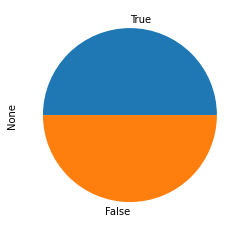

False


/home/hwang99/.anaconda3/envs/haicor-experiment/lib/python3.8/site-packages/scipy/stats/morestats.py:2958: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/hwang99/.anaconda3/envs/haicor-experiment/lib/python3.8/site-packages/scipy/stats/morestats.py:2972: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [7]:
for key, group in attentions.groupby(["story", "line", "character", "path"]):
    differences = pd.Series(abs(i - j) for i, j in itertools.combinations(group.value.unique(), 2))
    
    if len(differences) > 0 and differences.where(differences > 2 ** -23).count() > 0:
        (differences < 2 ** -23).value_counts().plot.pie()
        plt.show()
        
        print(stats.wilcoxon(differences - 2 ** -23, alternative="greater").pvalue < 0.001)